## 4.2 行列分解モデル

In [2]:
%matplotlib inline

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

### 4.2.1 モデル概要：主成分分析

### 4.2.2 モデル概要：ベイジアン主成分分析

### 4.2.3 実装：ベイジアン主成分分析

True principal axes:
[[ 1.62434536]
 [-0.61175641]]

True sigma:
0.8


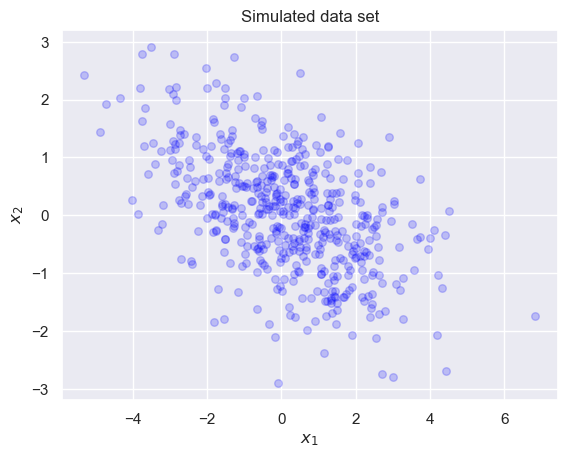

In [8]:
def build_toy_dataset(N, D, K, sigma=2.0, random_seed=1):
    np.random.seed(random_seed)
    x_train = np.zeros((D, N))
    w = np.random.normal(0.0, 1.0, size=(D, K))
    z = np.random.normal(0.0, 1.0, size=(K, N))
    mean = np.dot(w, z)
    for d in range(D):
        for n in range(N):
            x_train[d, n] = np.random.normal(mean[d, n], sigma)

    print("True principal axes:")
    print(w)
    print()
    print("True sigma:")
    print(sigma)
    return x_train

N = 500      # 観測データの数
D = 2        # 観測データの次元数
K = 1        # 潜在変数の次元数
sigma = 0.8

x_train = build_toy_dataset(N, D, K, sigma)

plt.scatter(x_train[0, :], x_train[1, :], color='blue', s=30, alpha=0.2)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title("Simulated data set")
plt.show()

In [9]:
import pymc3 as pm
with pm.Model() as model:
    w = pm.Normal("w", mu=np.zeros((D, K)), sd=np.ones((D, K)), shape=(D, K))
    z = pm.Normal("z", mu=np.zeros((N, K)), sd=np.ones((N, K)), shape=(N, K))
    sigma = pm.HalfCauchy("sigma", beta=5)
    x = pm.Normal("x", mu=w.dot(z.T), sd=sigma * np.ones((D, N)), shape=(D, N), observed=x_train)

In [10]:
with model:
    trace = pm.sample(2000, chains=3, random_seed=42, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [sigma, z, w]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


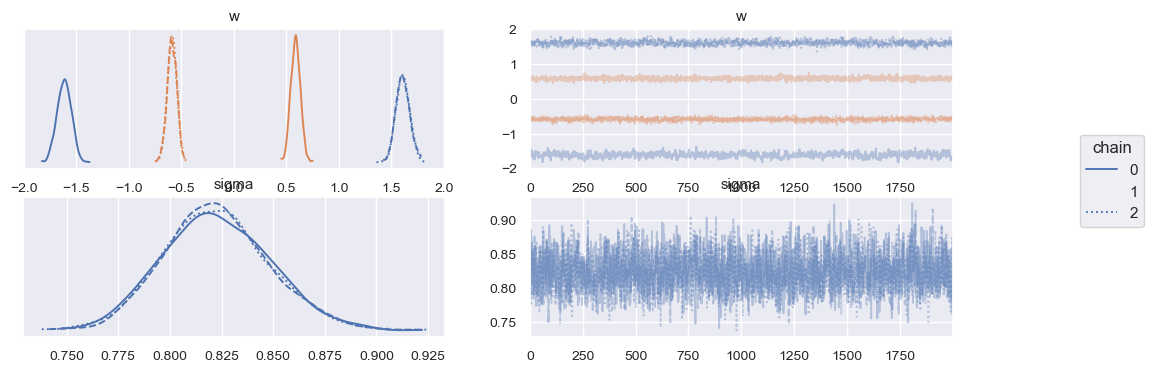

In [11]:
axes = az.plot_trace(trace, var_names=["w", "sigma"])
axes[0, 0].figure.legend([0, 1, 2], title="chain", loc="center left", bbox_to_anchor=(1.0, 0.5))

In [13]:
# 上記より今回のモデルでは, w と z の符号を反転させても同じ観測値 x が得られる (対称性がある) ため,
# w が一位に定まらないことが原因. このような場合, 全てのチェーンにおけるサンプルの平均値は無意味になるので
# 1 つのチェーンのみを使用する.
az.summary(trace.sel(chain=[0]), var_names=["w", "sigma"], kind="stats")

,mean,sd,hdi_3%,hdi_97%
"w[0, 0]",-1.614,0.067,-1.741,-1.494
"w[1, 0]",0.589,0.046,0.505,0.672
sigma,0.823,0.026,0.775,0.870


$$
\begin{align*}

\end{align*}
$$

/Users/yuta.sonoda/opt/anaconda3/envs/bayes_ml/lib/python3.10/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


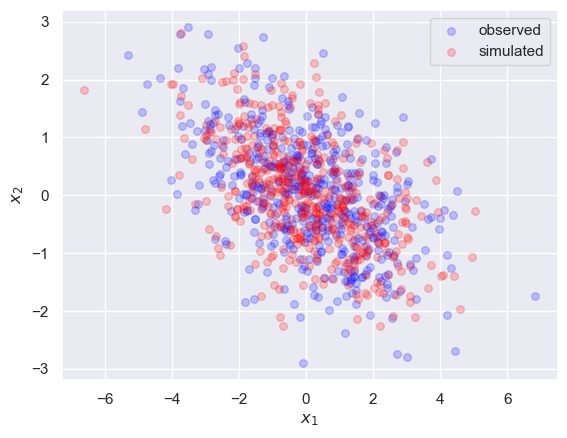

In [14]:
with model:
    x_post = pm.sample_posterior_predictive(trace, 1, random_seed=42)

plt.scatter(x_train[0, :], x_train[1, :], color="blue", s=30, alpha=0.2, label="observed")
plt.scatter(x_post["x"][0, 0, :], x_post["x"][0, 1, :], color="red", s=30, alpha=0.2, label="simulated")
plt.legend()
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

### 4.2.4 モデル概要：確率的行列分解

### 4.2.5 実装：確率的行列分解によるレコメンデーション

In [27]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [34]:
data = pd.read_csv(
    "http://files.grouplens.org/datasets/movielens/ml-100k/u.data",
    usecols=[0, 1, 2],
    names=["user_id", "item_id", "rating"],
    sep="\t"
)

display(data.head())

# 行列形式に変換
dense_data = data.pivot(index="user_id", columns="item_id", values="rating").values

num_users = dense_data.shape[0]
num_items = dense_data.shape[1]
sparsity = np.isnan(dense_data).mean()
print(f"Users: {num_users}\nMovies: {num_items}\nSparsity: {sparsity:.2f}")

,user_id,item_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


Users: 943
Movies: 1682
Sparsity: 0.94


count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

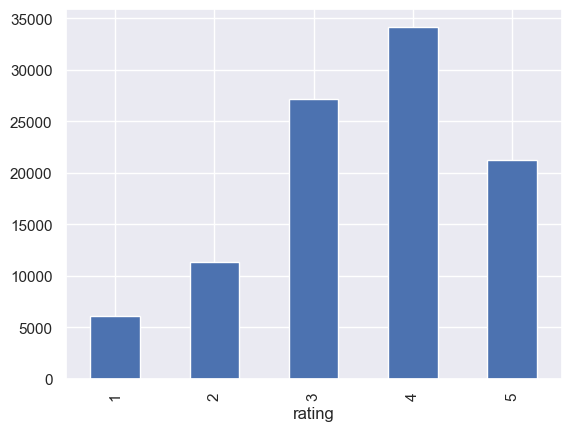

In [35]:
data.groupby("rating").size().plot(kind="bar")
display(data.rating.describe())

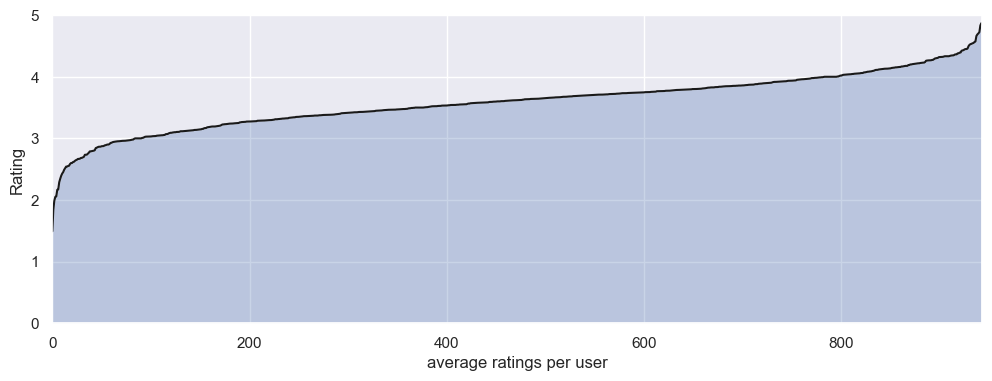

In [36]:
user_means = data.groupby("user_id")['rating'].mean().sort_values()
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.arange(len(user_means)), user_means.values, "k-")

ax.fill_between(np.arange(len(user_means)), user_means.values, alpha=0.3)
ax.set_ylabel("Rating")
ax.set_xlabel("average ratings per user")
ax.set_ylim(0, 5)
ax.set_xlim(0, len(user_means))
plt.show()

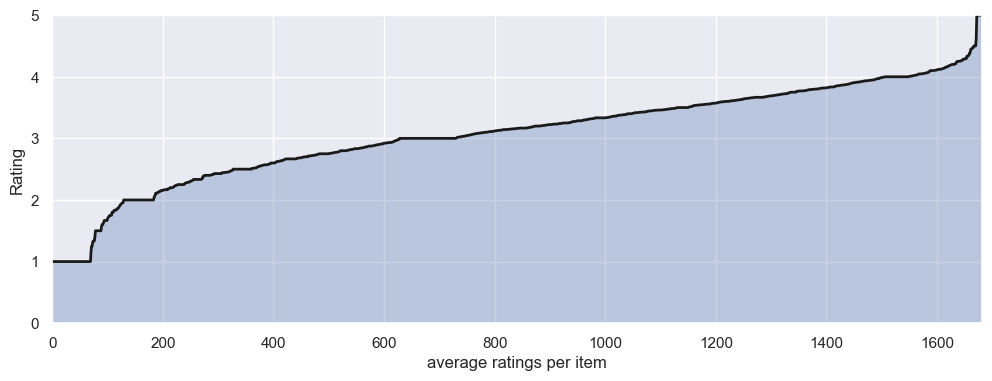

In [37]:
item_means = data.groupby("item_id")['rating'].mean().sort_values()
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.arange(len(item_means)), item_means.values, "k-", lw=2)

ax.fill_between(np.arange(len(item_means)), item_means.values, alpha=0.3)
ax.set_ylabel("Rating")
ax.set_xlabel("average ratings per item")
ax.set_ylim(0, 5)
ax.set_xlim(0, len(item_means))
plt.show()

In [38]:
def split_train_test(data, test_ratio=0.1, random_seed=1):
    """学習データとテストデータに分割"""
    np.random.seed(random_seed)

    # 学習・テストデータを格納する変数を用意
    train = data.copy()
    test = np.ones(data.shape) * np.nan

    # 学習データの一部をランダムに抽出し、テストデータとする
    to_sample = np.where(~np.isnan(train))
    # 欠損でない評価値のインデックス（行番号・列番号のタプル）のリスト
    idx_pairs = list(zip(to_sample[0], to_sample[1]))

    test_size = int(len(idx_pairs) * test_ratio)
    train_size = len(idx_pairs) - test_size

    indices = np.arange(len(idx_pairs))
    # テストデータとする評価値のインデックスの番号
    sample = np.random.choice(indices, replace=False, size=test_size)

    # 学習データからテストデータに移し替える
    for idx in sample:
        idx_pair = idx_pairs[idx]
        test[idx_pair] = train[idx_pair]
        train[idx_pair] = np.nan

    # 念のため分割後のデータを確認
    assert(train_size == (~np.isnan(train)).sum())
    assert(test_size == (~np.isnan(test)).sum())

    return train, test


def baseline_prediction(train_data):
    """ユーザーごとの平均、映画ごとの平均、全体の平均の3つの平均の平均値を予測値とするベースライン"""
    nan_mask = np.isnan(train_data)
    masked_train = np.ma.masked_array(train_data, nan_mask)
    global_mean = masked_train.mean()
    user_means = masked_train.mean(axis=1)
    item_means = masked_train.mean(axis=0)

    pred = train_data.copy()
    n, m = train_data.shape
    for i in range(n):
        for j in range(m):
            if np.ma.isMA(item_means[j]):
                pred[i, j] = np.mean(
                    (global_mean, user_means[i]))
            else:
                pred[i, j] = np.mean(
                    (global_mean, user_means[i], item_means[j]))
    return pred


def rmse(test_data, predicted):
    """テストデータにおけるRMSEを算出。欠損値は無視する。"""
    I = ~np.isnan(test_data)
    N = I.sum()
    sqerror = np.abs(test_data - predicted) ** 2
    mse = sqerror[I].sum() / N
    return np.sqrt(mse)

In [43]:
train, test = split_train_test(dense_data)

baseline = baseline_prediction(train)
baseline_score = rmse(test, baseline)
print(f"RMSE of baseline: {baseline_score:.2f}")

RMSE of baseline: 1.02


In [53]:
dtype = np.float32

latent_dim = 5   # 潜在変数の次元
bounds = (1, 5)  # レーティングのとりうる範囲
n_user, n_item = train.shape

# 学習データにおける欠損値のインデックス
nan_mask = np.isnan(train)

# U, V の標準偏差は, それぞれのユーザー, アイテムの標準偏差の平均値に固定
train_fill = train.copy()
train_fill[nan_mask] = train[~nan_mask].mean()
stddev_U = train_fill.std(axis=1).mean().astype(dtype)
stddev_V = train_fill.std(axis=0).mean().astype(dtype)

# R の標準偏差は固定値に設定
alpha = 2.0
stddev_datapoints = np.sqrt(1 / alpha).astype(dtype)


def pmf():
    Root = tfd.JointDistributionCoroutine.Root

    # ユーザー
    # 事前分布より Root で囲む
    U = yield Root(
        tfd.Independent(
            tfd.Normal(
                loc=tf.zeros([n_user, latent_dim]),
                scale=stddev_U * tf.ones([n_user, latent_dim]),
                name="U"
            ),
            reinterpreted_batch_ndims=2
        )
    )

    # アイテム
    # 事前分布より Root で囲む
    V = yield Root(
        tfd.Independent(
            tfd.Normal(
                loc=tf.zeros([latent_dim, n_item]),
                scale=stddev_V * tf.ones([latent_dim, n_item]),
                name="V"
            ),
            reinterpreted_batch_ndims=2
        )
    )

    R = yield tfd.Independent(
        tfd.Normal(
            loc=tf.matmul(U, V)[~nan_mask],
            scale=stddev_datapoints,
            name="R"
        ),
        reinterpreted_batch_ndims=1
    )


model = tfd.JointDistributionCoroutine(pmf)

# パラメータ U, V と学習データを与えて対数事後確率を計算する.
target_log_prob_fn = lambda U, V: model.log_prob(U, V, train[~nan_mask])

In [54]:
def init_random(shape, n_chains=1, r=2):
    """
    StanのようにUniform(-2, 2)で初期化する
    """
    if n_chains == 1:
        return tf.random.uniform(shape, -r, r)
    else:
        return tf.random.uniform([n_chains,] + shape, -r, r)

In [55]:
num_results = 1000
num_burnin_steps = 1000

@tf.function
def do_sampling():
    return tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        num_steps_between_results=5,  # 5 つのサンプルごとに 1 つだけ間引いて事後分布からのサンプルとする
        # パラメータの初期値
        current_state=[
            init_random((n_user, latent_dim)),
            init_random((latent_dim, n_item))
        ],
        kernel=tfp.mcmc.SimpleStepSizeAdaptation(
            tfp.mcmc.HamiltonianMonteCarlo(
                target_log_prob_fn=target_log_prob_fn,
                step_size=0.1,
                num_leapfrog_steps=10
            ),
            num_adaptation_steps=int(num_burnin_steps * 0.8)
        )
    )

states, kernel_results = do_sampling()

/Users/yuta.sonoda/opt/anaconda3/envs/bayes_ml/lib/python3.10/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


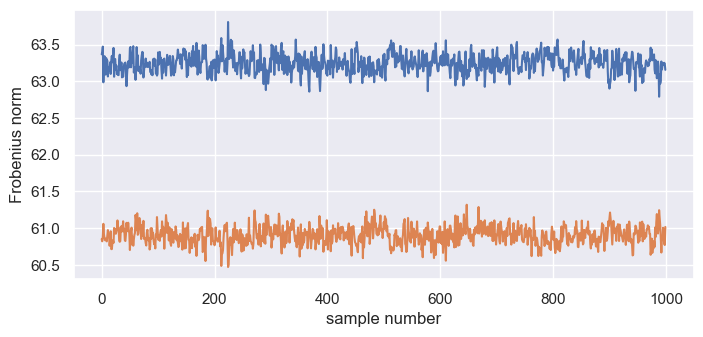

In [59]:
U_norm = np.linalg.norm(states[0], axis=(1, 2))
V_norm = np.linalg.norm(states[1], axis=(1, 2))

plt.figure(figsize=(8, 3.5))
plt.plot(U_norm, label="U")
plt.plot(V_norm, label="V")
plt.xlabel("sample number")
plt.ylabel("Frobenius norm")
plt.show()

In [76]:
def predict(u, v, sd, bounds=(1, 5)):
    r = tf.matmul(u, v)

    # R のサンプルを取得
    sample_r = tfd.Normal(loc=r, scale=sd).sample()

    # レーティングの上限・下限に収まるようにクリッピング
    sample_r = tf.clip_by_value(sample_r, *bounds)
    return  sample_r


def running_rmse(states, train_data, test_data, burnin=0):
    from tqdm import tqdm

    states = [s[burnin:] for s in states]
    results = {
        "per-step-train": [],
        "running-train": [],
        "per-step-test": [],
        "running-test": [],
    }
    r = np.zeros(train_data.shape)
    for i in tqdm(range(len(states[0]))):
        # U, V のサンプルから R のサンプルを取得.
        sample_r = predict(states[0][i], states[1][i], stddev_datapoints).numpy()
        r += sample_r

        # 現時点までのサンプル平均
        running_r = r / (i + 1)

        # RMSE の算出
        results["per-step-train"].append(rmse(train_data, sample_r))
        results["running-train"].append(rmse(train_data, running_r))
        results["per-step-test"].append(rmse(test_data, sample_r))
        results["running-test"].append(rmse(test_data, running_r))

    results = pd.DataFrame(results)
    return running_r, results


pred, results = running_rmse(states, train, test)

test_rmse = results["running-test"].values[-1]
train_rmse = results["running-train"].values[-1]
print(f"train RMSE: {train_rmse:.3f}")
print(f"test RMSE: {test_rmse:.3f}")
print(f"test RMSE(baseline): {baseline_score:.3f}")

100%|██████████| 1000/1000 [00:30<00:00, 32.93it/s]

train RMSE: 0.859
test RMSE: 0.944
test RMSE(baseline): 1.017


<AxesSubplot:xlabel='average ratings per item', ylabel='Rating'>

Text(0, 0.5, 'RMSE')

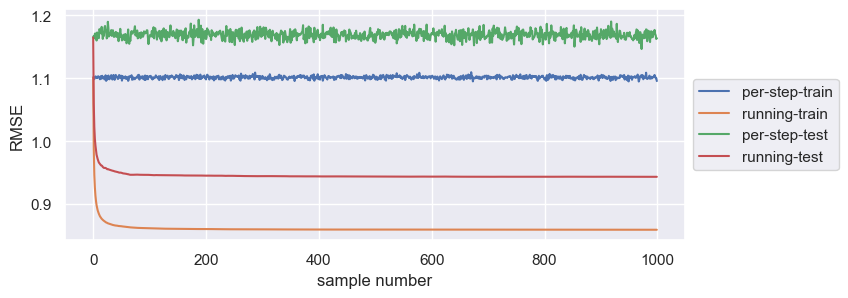

In [77]:
fig, ax = plt.subplots(figsize=(8, 3))
results.plot(ax=ax)
ax.legend(loc='center left', bbox_to_anchor=[1.0, 0.5])
ax.set_xlabel('sample number')
ax.set_ylabel('RMSE')